In [35]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

Settings

In [36]:
target_column = 'classes'
text_column = 'prompts'
unusable_columns = []

Read Data

In [37]:
data = pd.read_csv('train_all.csv').drop(columns=unusable_columns)

Utility function

In [38]:
def remove_stop_words(sentence:str) -> str:
    new_words = word_tokenize(sentence)
    new_filtered_words = [
    word for word in new_words if word.lower() not in stopwords.words('english')]
    return ' '.join(new_filtered_words)
 

Encode Targets

In [39]:
label_encoder = LabelEncoder()
data[target_column] = label_encoder.fit_transform(data[target_column])

Get K-Folds

In [40]:
splitter = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
folds = list(splitter.split(data[text_column], data[target_column]))

Perform CV Training

In [41]:
models = []
accuracies = []
oof_predictions = []
true_labels = []

#embedding_save_dir: str = 'src/data/extra/'
#embedding_filename: str = 'embeddings_english'
#vectorized_data = np.load(embedding_save_dir + embedding_filename+'.npy')

for train_idx, test_idx in folds:
    train_data = data.loc[train_idx]
    test_data = data.loc[test_idx]
    #train_vectors = vectorized_data[train_idx]
    #test_vectors = vectorized_data[test_idx]
    vectorizer = TfidfVectorizer()
    train_vectors =  vectorizer.fit_transform(train_data[text_column])
    model = XGBClassifier()
    model.fit(train_vectors, train_data[target_column])
    test_vectors = vectorizer.transform(test_data[text_column])
    predictions = model.predict(test_vectors)
    accuracy = accuracy_score(test_data[target_column], predictions)
    models.append(model)
    oof_predictions.append(predictions)
    true_labels.append(test_data[target_column])
    accuracies.append(accuracy)
print(np.mean(accuracies))
accuracies

0.7783333333333333


[0.75, 0.8, 0.85, 0.74, 0.81, 0.72]

Plot results

['Complex' 'Simple']


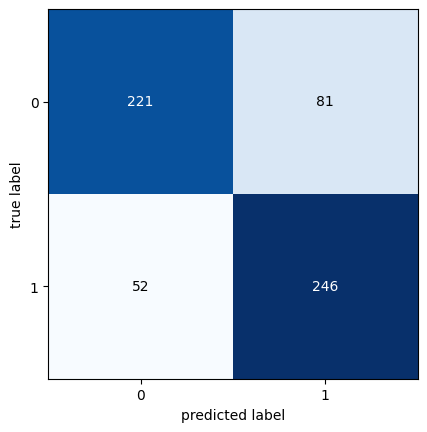

In [42]:
plot_confusion_matrix(confusion_matrix(np.concatenate(true_labels), np.concatenate(oof_predictions)))
print(label_encoder.inverse_transform([0,1]))